## TODO:
* when eta is high, the battery will charge and discharge more often. This leads to alot of dots in the 2nd figure. 
* run code for 2 setups with high (realistic) and low eta

In [50]:
%load_ext autoreload
%autoreload 2
from tools_nk import EnergyStorageModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import numpy as np
# how do align 

## ETA HIGH

In [96]:
model = EnergyStorageModel(eta_charge=0.8, 
                           eta_discharge=0.8, 
                           beta = 0.99,
                           a_bar = 10,
                           max_battery_capacity=10,
                           num_storage_levels=12,
                           num_actions=14,
                           num_price_levels=10,
                           tolerance = 1e-4,
                           max_iteration=10_000,
                           simulate_prices = True,
                           mean_reversion= 0.3,
                           p_variance = 100,
                           risk_averse=True,
                           risk_parameter=0.01)

simulating data
Simulating price series...


In [95]:
# Example Usage:
V, P = model.vfi_vec(allow_NK=True) 


Starting Value Function Iteration...
Iteration 0: change in value = 2.658e+00, cumulative change in policy = 8.46
Iteration 1: change in value = 2.020e+00, cumulative change in policy = 7.69
Iteration 2: change in value = 1.677e+00, cumulative change in policy = 3.08
Iteration 3: change in value = 1.478e+00, cumulative change in policy = 1.54
Iteration 4: change in value = 1.354e+00, cumulative change in policy = 1.54
Iteration 5: change in value = 1.273e+00, cumulative change in policy = 1.54
Iteration 6: change in value = 1.215e+00, cumulative change in policy = 1.54
Iteration 7: change in value = 1.172e+00, cumulative change in policy = 1.54
Iteration 8: change in value = 1.138e+00, cumulative change in policy = 1.54
Iteration 9: change in value = 1.110e+00, cumulative change in policy = 1.54
check_V = 0.23190802300322844
check_NK - beta = 8.79296635503124e-14
start NK at iter = 158
Starting Policy Function Iteration.
Iteration 0: change in value = 3.061e+01, change in policy = 0.00

In [100]:
V_2 , P_2 = model.pfi_vec()

Starting Policy Function Iteration.
Iteration 0: change in value = 1.033e+03, change in policy = 9.23
Iteration 1: change in value = 9.007e+02, change in policy = 6.15
Iteration 2: change in value = 7.451e+02, change in policy = 9.23
Iteration 3: change in value = 1.871e+03, change in policy = 9.23
Iteration 4: change in value = 8.905e+02, change in policy = 9.23
Iteration 5: change in value = 1.431e+03, change in policy = 9.23
Iteration 6: change in value = 9.184e+02, change in policy = 9.23
Iteration 7: change in value = 1.214e+03, change in policy = 9.23
Iteration 8: change in value = 2.941e+03, change in policy = 9.23
Iteration 9: change in value = 2.383e+03, change in policy = 9.23
Iteration 1000: change in value = 1.052e+03, change in policy = 9.23
Iteration 2000: change in value = 1.052e+03, change in policy = 9.23
Iteration 3000: change in value = 1.052e+03, change in policy = 9.23
Iteration 4000: change in value = 1.052e+03, change in policy = 9.23
Iteration 5000: change in va

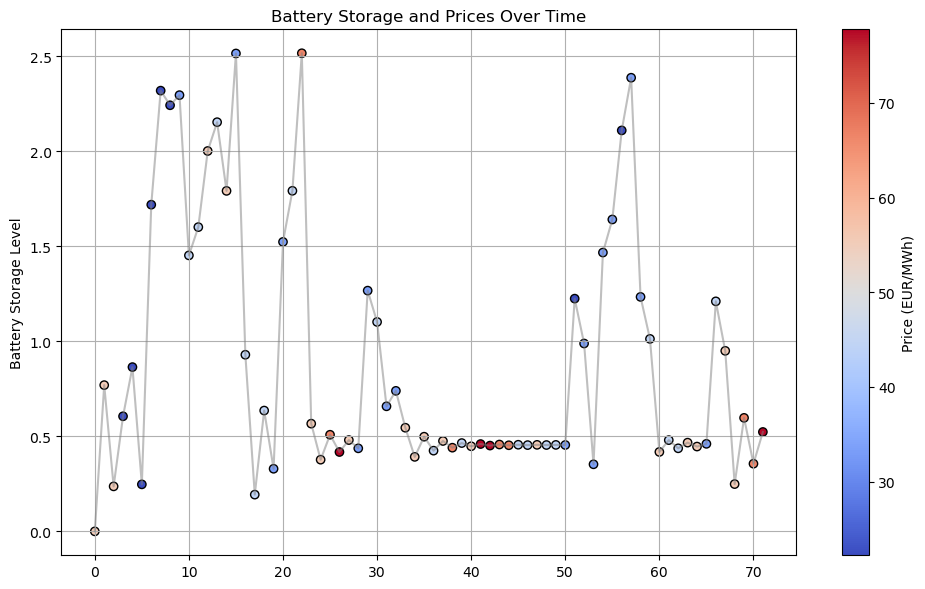

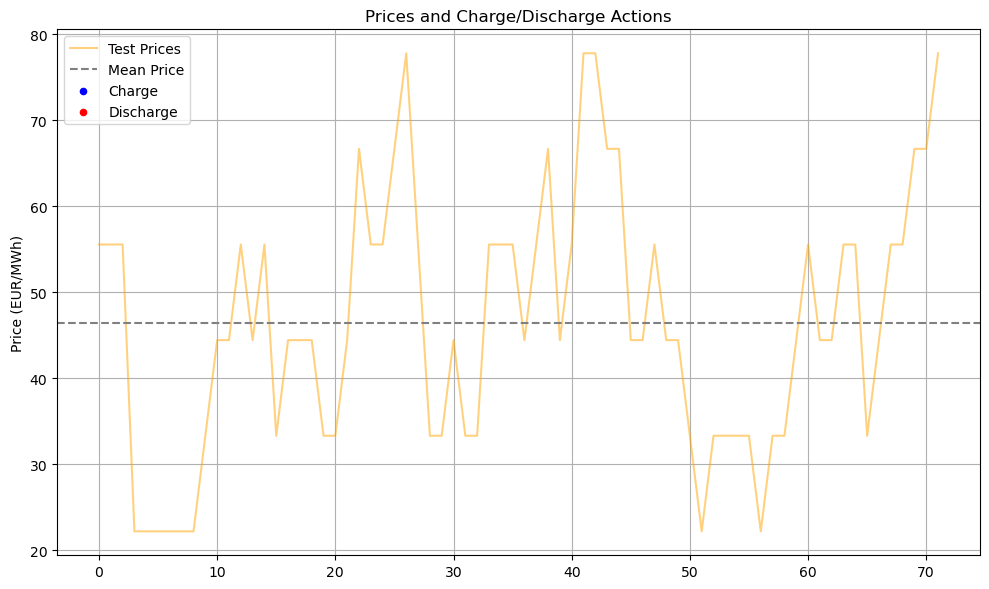

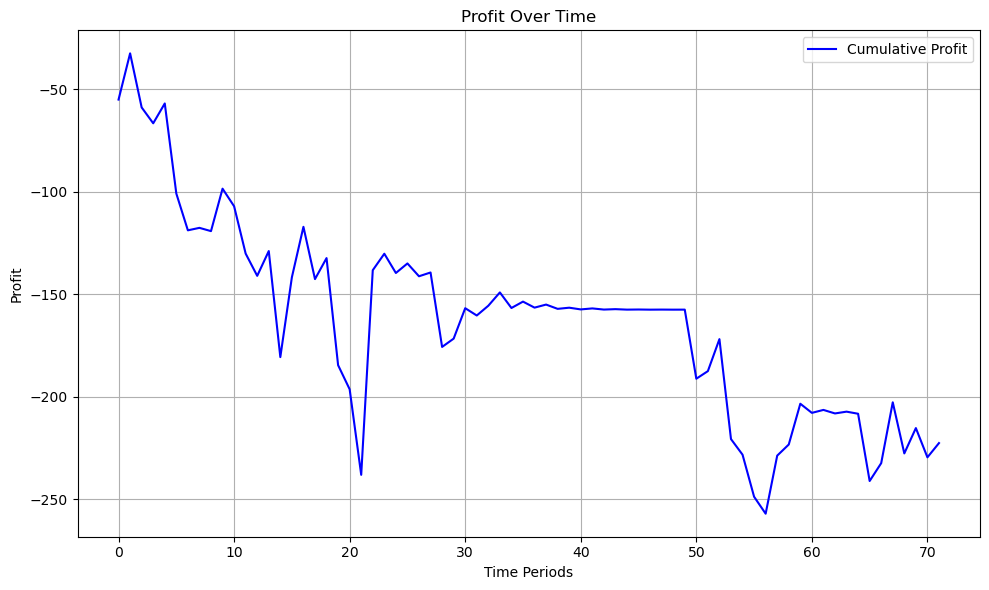

you earned: -167.53820732667452


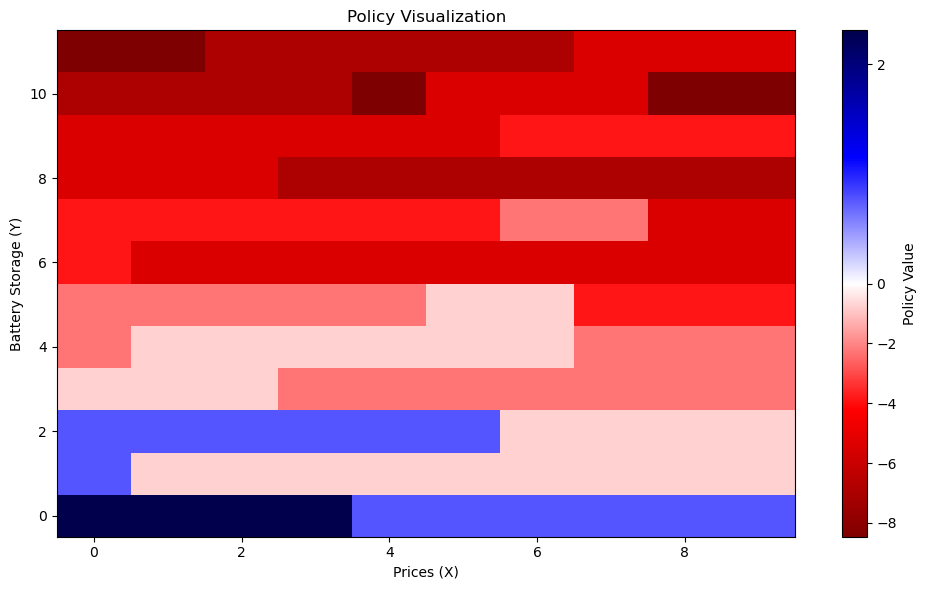

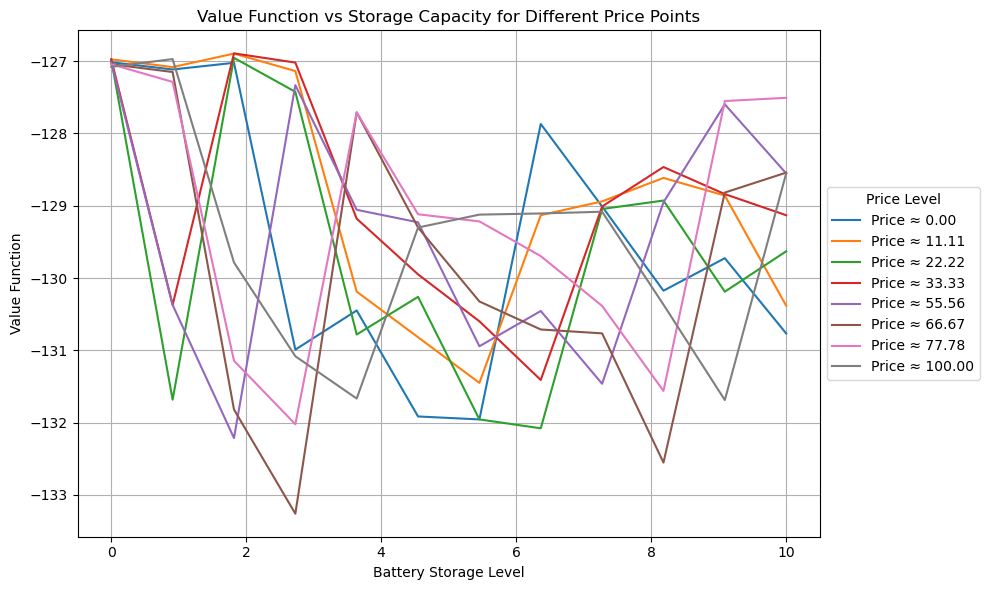

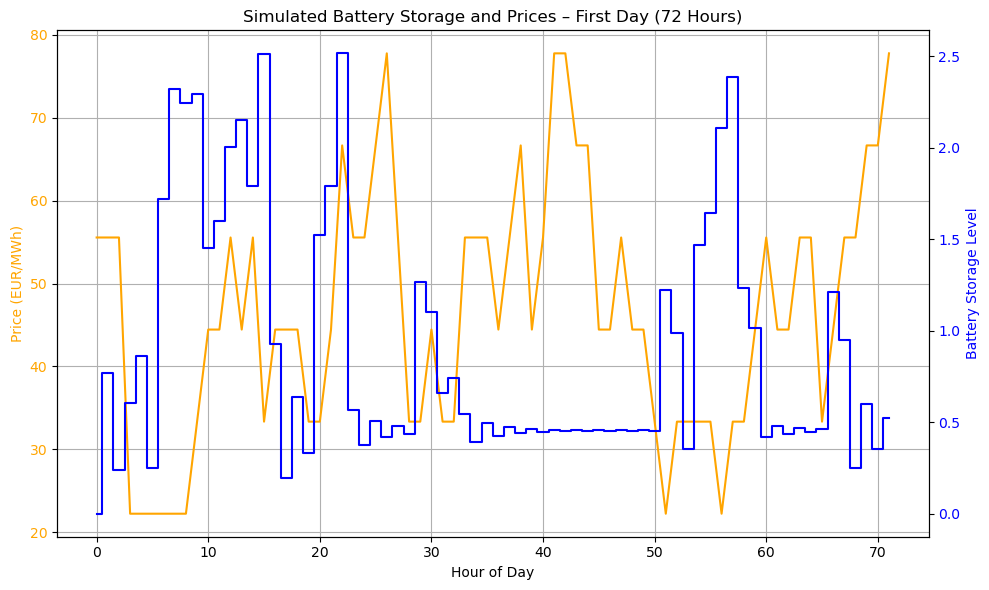

In [98]:
battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P_2)
model.plot_results(battery_storage_sim, profit_sim, action_sim)

In [ ]:
V, P = model.pfi_vec() 

In [182]:
# 
model = EnergyStorageModel(eta_charge=0.98, 
                           eta_discharge=0.97, 
                           beta = 0.999,
                           a_bar = 10,
                           num_storage_levels=10,
                           num_actions=11,
                           num_price_levels=12,
                           tolerance = 1e-4, # if tol is too small, overflow in nk function
                           max_iteration=10_000,
                           simulate_prices = True,
                           mean_reversion= 0.3,
                           p_variance = 100,
                           risk_averse=True,
                           risk_parameter=0.01)

simulating data
Simulating price series...


In [181]:
V, P = model.vfi_vec(allow_NK=True) 
battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
# model.plot_results(battery_storage_sim, profit_sim, action_sim)

Starting Value Function Iteration...
Iteration 0: change in value = 1.000e+00, cumulative change in policy = 8.00
Iteration 1: change in value = 9.990e-01, cumulative change in policy = 10.00
Iteration 2: change in value = 9.980e-01, cumulative change in policy = 4.00
Iteration 3: change in value = 9.970e-01, cumulative change in policy = 2.00
Iteration 4: change in value = 9.960e-01, cumulative change in policy = 2.00
Iteration 5: change in value = 9.950e-01, cumulative change in policy = 2.00
Iteration 6: change in value = 9.940e-01, cumulative change in policy = 2.00
Iteration 7: change in value = 9.929e-01, cumulative change in policy = 2.00
Iteration 8: change in value = 9.918e-01, cumulative change in policy = 2.00
Iteration 9: change in value = 9.907e-01, cumulative change in policy = 2.00
Iteration 1000: change in value = 3.652e-01, cumulative change in policy = 24.00
check_V = 0.20856904706954538
check_NK - beta = 4.056754931980322e-13
start NK at iter = 1560
Starting Policy F

In [184]:
V_2, P_2 = model.pfi_vec() 

Starting Policy Function Iteration.
Iteration 0: change in value = 1.630e+00, change in policy = 2.00
Iteration 1: change in value = 8.388e+00, change in policy = 2.00
Iteration 2: change in value = 1.513e+01, change in policy = 2.00
Iteration 3: change in value = 5.123e+00, change in policy = 2.00
Iteration 4: change in value = 9.673e+00, change in policy = 2.00
Iteration 5: change in value = 1.466e+01, change in policy = 2.00
Iteration 6: change in value = 5.297e+00, change in policy = 2.00
Iteration 7: change in value = 9.737e+00, change in policy = 2.00
Iteration 8: change in value = 1.463e+01, change in policy = 2.00
Iteration 9: change in value = 5.305e+00, change in policy = 2.00
Iteration 1000: change in value = 9.740e+00, change in policy = 2.00


KeyboardInterrupt: 

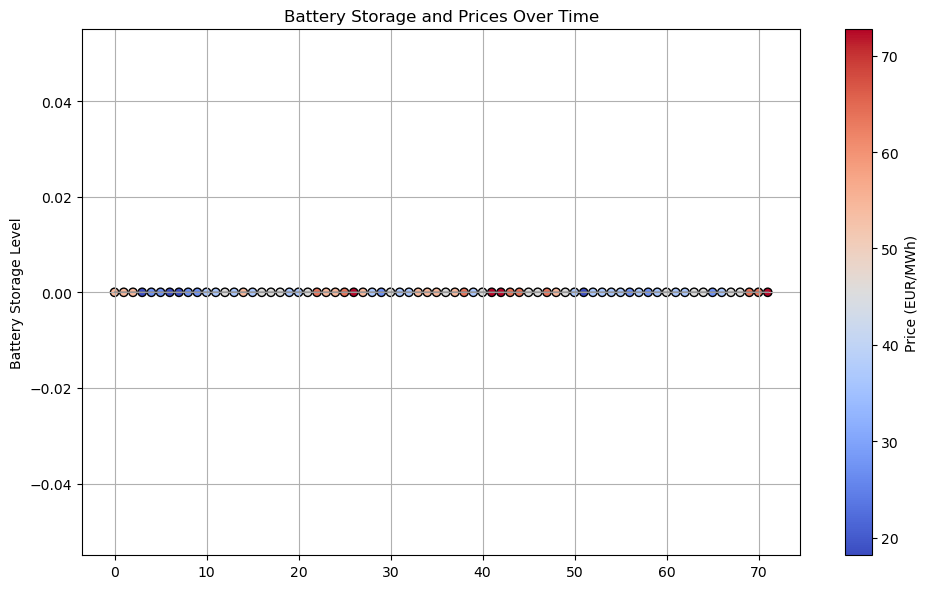

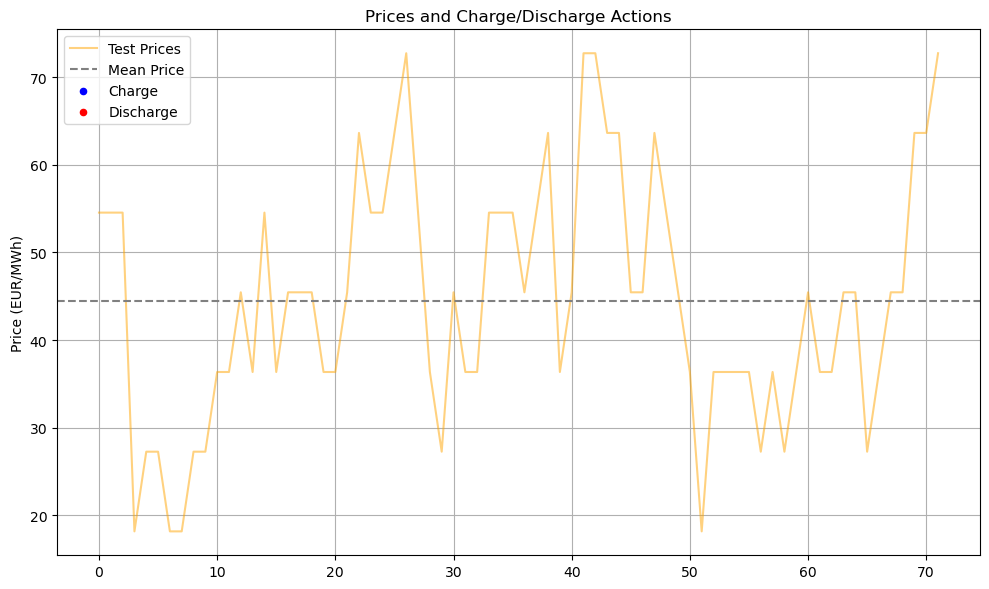

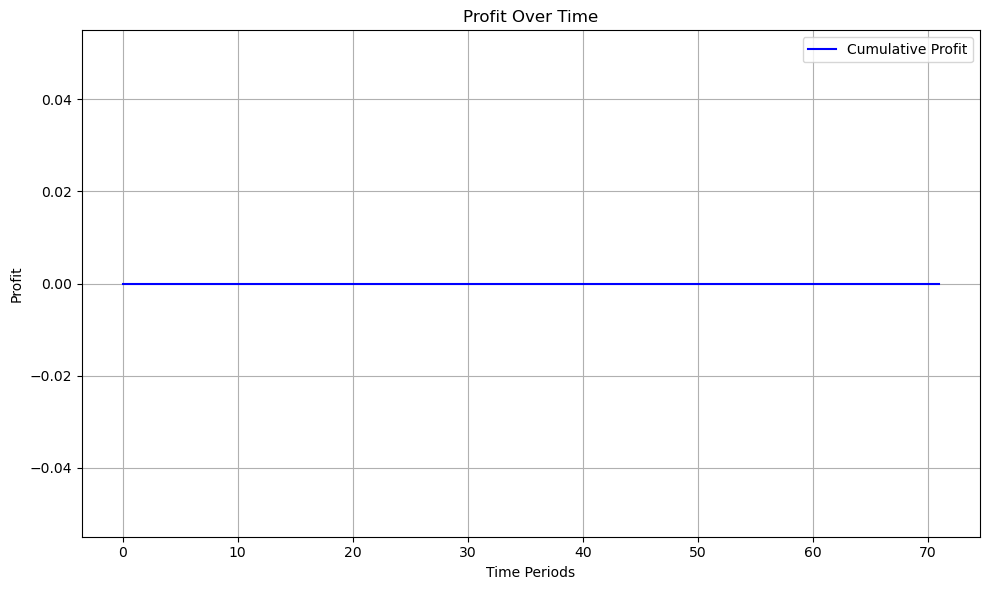

you earned: 0.0


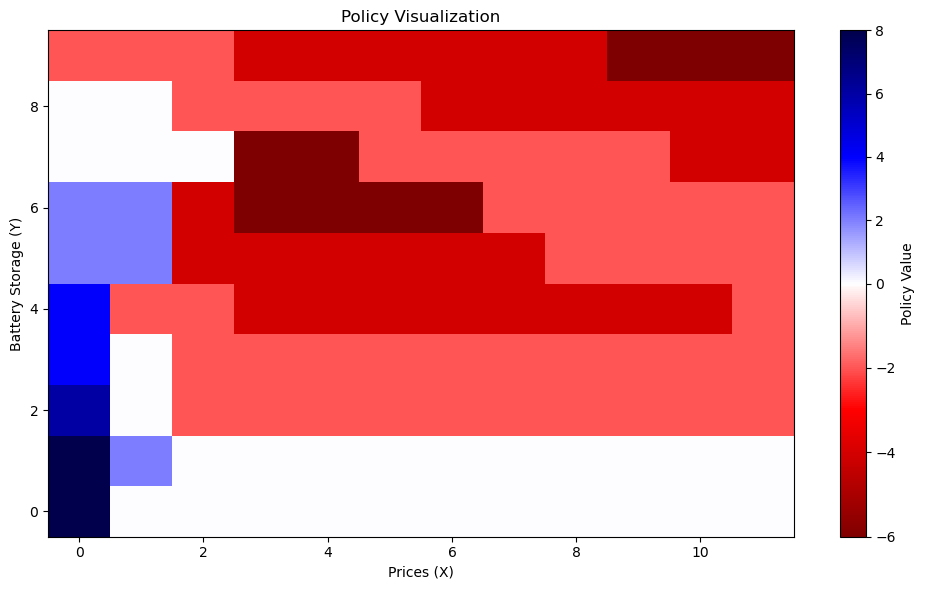

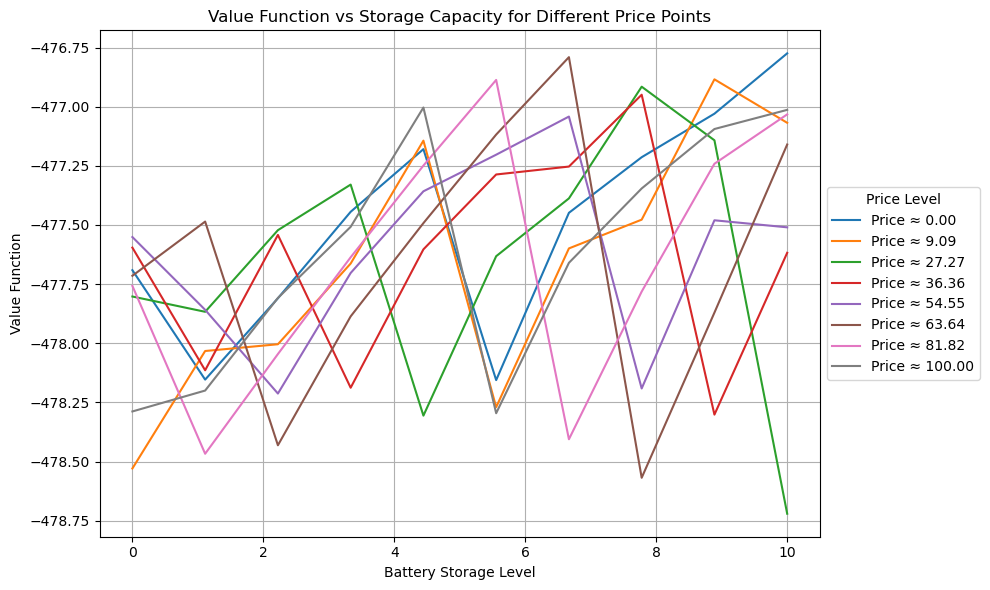

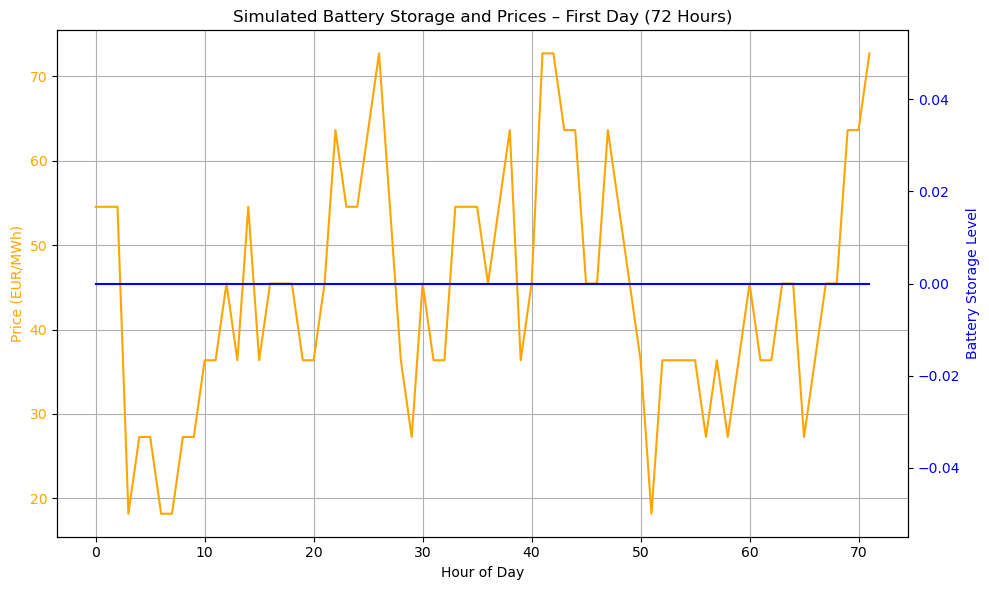

In [176]:
battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P_2)
model.plot_results(battery_storage_sim, profit_sim, action_sim)

In [35]:
print(model.policy)
print(model.price_transitions)

[[10.     5.385  2.308  0.769  0.769  0.769  0.769  0.769  0.769  0.769]
 [ 8.462  5.385  2.308  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769]
 [ 6.923  5.385  2.308  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 6.923  5.385  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 5.385  3.846  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 5.385  3.846  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 3.846  3.846  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 2.308  2.308  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 2.308  2.308  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 0.769  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [ 0.769  0.769  0.769  0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769]
 [-0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769 -0.769]]
[[0.146 0.417 0.347 0.084 0.006 0.    0.    0.    0.    0.   ]
 [0.033 0.225 0.443 0.254 0.042 0.002 0.    0.    0.    0.  

In [ ]:
import numpy as np

def make_Q(model):
    # Given policy: shape (n_storage, n_price)
    policy = model.policy
    n_storage, n_price = policy.shape

    # Given price transition matrix (10x10)
    transition_price = model.price_transitions

    # Storage states 0..n_storage-1
    storage_levels = np.arange(n_storage)[:, None]  # shape (n_storage,1)

    # Compute next storage as continuous, then discretize by rounding and clip to bounds
    next_storage_float = storage_levels + policy  # shape (n_storage, n_price)
    next_storage_idx = np.clip(np.round(next_storage_float).astype(int), 0, n_storage - 1)  # int indices

    # Flatten states (combined storage & price)
    n_states = n_storage * n_price
    curr_states = np.arange(n_states)
    curr_storage = curr_states % n_storage
    curr_price = curr_states // n_storage

    # next_storage_idx for current states: indexing (curr_storage, curr_price)
    next_storage_flat = next_storage_idx[curr_storage, curr_price]  # shape (n_states,)

    # Price transition probabilities for current prices
    price_probs = transition_price[curr_price]  # shape (n_states, n_price)

    # Compute next states for all possible price transitions:
    # next_state = next_price * n_storage + next_storage
    next_states = np.arange(n_price)[None, :] * n_storage + next_storage_flat[:, None]  # (n_states, n_price)

    # Construct transition matrix Q: (n_states, n_states)
    Q = np.zeros((n_states, n_states))

    rows = np.repeat(curr_states, n_price)
    cols = next_states.flatten()
    vals = price_probs.flatten()

    Q[rows, cols] = vals

    # Validate row sums
    assert np.allclose(Q.sum(axis=1), 1), "Transition matrix rows must sum to 1"

    return Q 

# Output for inspection
np.set_printoptions(precision=3, suppress=True, linewidth=120)
print("Full Q matrix:")
print(Q)
print(Q[0,:])


Full Q matrix:
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.146 0.    0.   ]
 [0.    0.    0.    ... 0.    0.146 0.   ]]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.146 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.417 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.347 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.084 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.006 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]


In [48]:
rows, cols = np.nonzero(Q)
for r, c in zip(rows, cols):
    print(f"Q[{r}, {c}] = {Q[r, c]:.3f}")

Q[0, 9] = 0.146
Q[0, 19] = 0.417
Q[0, 29] = 0.347
Q[0, 39] = 0.084
Q[0, 49] = 0.006
Q[0, 59] = 0.000
Q[0, 69] = 0.000
Q[0, 79] = 0.000
Q[0, 89] = 0.000
Q[0, 99] = 0.000
Q[1, 9] = 0.146
Q[1, 19] = 0.417
Q[1, 29] = 0.347
Q[1, 39] = 0.084
Q[1, 49] = 0.006
Q[1, 59] = 0.000
Q[1, 69] = 0.000
Q[1, 79] = 0.000
Q[1, 89] = 0.000
Q[1, 99] = 0.000
Q[2, 9] = 0.146
Q[2, 19] = 0.417
Q[2, 29] = 0.347
Q[2, 39] = 0.084
Q[2, 49] = 0.006
Q[2, 59] = 0.000
Q[2, 69] = 0.000
Q[2, 79] = 0.000
Q[2, 89] = 0.000
Q[2, 99] = 0.000
Q[3, 9] = 0.146
Q[3, 19] = 0.417
Q[3, 29] = 0.347
Q[3, 39] = 0.084
Q[3, 49] = 0.006
Q[3, 59] = 0.000
Q[3, 69] = 0.000
Q[3, 79] = 0.000
Q[3, 89] = 0.000
Q[3, 99] = 0.000
Q[4, 9] = 0.146
Q[4, 19] = 0.417
Q[4, 29] = 0.347
Q[4, 39] = 0.084
Q[4, 49] = 0.006
Q[4, 59] = 0.000
Q[4, 69] = 0.000
Q[4, 79] = 0.000
Q[4, 89] = 0.000
Q[4, 99] = 0.000
Q[5, 8] = 0.146
Q[5, 18] = 0.417
Q[5, 28] = 0.347
Q[5, 38] = 0.084
Q[5, 48] = 0.006
Q[5, 58] = 0.000
Q[5, 68] = 0.000
Q[5, 78] = 0.000
Q[5, 88] = 0.000
Q[5

In [16]:
import numpy as np
import pandas as pd

# Parameters
n_storage = 3
n_price = 2
n_states = n_storage * n_price

# Policy (absolute target storage values)
policy = np.array([
    [2, 1],  # storage = 0
    [1, 0],  # storage = 1
    [0, 0],  # storage = 2
])

# Price transition matrix
transition_price = np.array([
    [0.8, 0.2],
    [0.4, 0.6],
])

# Battery storage states
battery_storage = np.array([0, 1, 2])

# Compute next storage level under policy
stor_next = policy + battery_storage[:, None]
stor_next = np.clip(stor_next, 0, n_storage - 1)

# Storage transition matrix (deterministic)
transition_stor = np.zeros((n_storage, n_price, n_storage))
for s in range(n_storage):
    for p in range(n_price):
        s_next = stor_next[s, p]
        transition_stor[s, p, s_next] = 1.0

# Build full transition matrix Q
Q = np.zeros((n_states, n_states))
for s in range(n_storage):
    for p in range(n_price):
        curr_index = p * n_storage + s
        for s_ in range(n_storage):
            s_prob = transition_stor[s, p, s_]
            for p_ in range(n_price):
                next_index = p_ * n_storage + s_
                Q[curr_index, next_index] += s_prob * transition_price[p, p_]

# Build labeled indices for price and storage combinations
index_labels = [(p, s) for p in range(n_price) for s in range(n_storage)]
index = pd.MultiIndex.from_tuples(index_labels, names=["price", "storage"])

# Create labeled Q matrix as DataFrame
Q_df = pd.DataFrame(Q, index=index, columns=index)

# Display result
print("\nLabeled transition matrix Q (rows and columns as (price, storage)):")
print(Q_df.round(2))



Labeled transition matrix Q (rows and columns as (price, storage)):
price            0              1          
storage          0    1    2    0    1    2
price storage                              
0     0        0.0  0.0  0.8  0.0  0.0  0.2
      1        0.0  0.0  0.8  0.0  0.0  0.2
      2        0.0  0.0  0.8  0.0  0.0  0.2
1     0        0.0  0.4  0.0  0.0  0.6  0.0
      1        0.0  0.4  0.0  0.0  0.6  0.0
      2        0.0  0.0  0.4  0.0  0.0  0.6


In [107]:
# 
Q = model.make_Q()

# Build labeled indices for price and storage combinations
index_labels = [(p, s) for p in model.price_grid for s in model.battery_grid]
index = pd.MultiIndex.from_tuples(index_labels, names=["price", "storage"])

# Create labeled Q matrix as DataFrame
Q_df = pd.DataFrame(Q, index=index, columns=index)
Q_df

price                 0.0                               50.0             \
storage                0.0           5.0       10.0      0.0       5.0    
price storage                                                             
0.0   0.0      0.000000e+00  0.000000e+00  0.993307  0.000000  0.000000   
      5.0      0.000000e+00  0.000000e+00  0.993307  0.000000  0.000000   
      10.0     0.000000e+00  9.933071e-01  0.000000  0.000000  0.006693   
50.0  0.0      0.000000e+00  3.726625e-06  0.000000  0.000000  0.999993   
      5.0      0.000000e+00  0.000000e+00  0.000004  0.000000  0.000000   
      10.0     0.000000e+00  3.726625e-06  0.000000  0.000000  0.999993   
100.0 0.0      0.000000e+00  6.262918e-16  0.000000  0.000000  0.006693   
      5.0      6.262918e-16  0.000000e+00  0.000000  0.006693  0.000000   
      10.0     0.000000e+00  6.262918e-16  0.000000  0.000000  0.006693   

price                       100.0                              
storage            10.0      0.0           5.0           10.0  
price storage                                                  
0.0   0.0      0.006693  0.000000  0.000000e+00  6.262918e-16  
      5.0      0.006693  0.000000  0.000000e+00  6.262918e-16  
      10.0     0.000000  0.000000  6.262918e-16  0.000000e+00  
50.0  0.0      0.000000  0.000000  3.726625e-06  0.000000e+00  
      5.0      0.999993  0.000000  0.000000e+00  3.726625e-06  
      10.0     0.000000  0.000000  3.726625e-06  0.000000e+00  
100.0 0.0      0.000000  0.000000  9.933071e-01  0.000000e+00  
      5.0      0.000000  0.993307  0.000000e+00  0.000000e+00  
      10.0     0.000000  0.000000  9.933071e-01  0.000000e+00

In [ ]:
# Policy (absolute target storage values)
policy = np.array([
    [2, 1],  # storage = 0
    [1, 0],  # storage = 1
    [0, 0],  # storage = 2
])

# Price transition matrix
transition_price = np.array([
    [0.8, 0.2], 
    [0.4, 0.6],
])


In [9]:
import numpy as np

# Define policy as Δstorage (change)
# e.g., +1 = charge, -1 = discharge, 0 = hold
delta_policy = np.array([
    [1,  0],   # storage = 0 → charge if low, hold if high
    [1, -1],   # storage = 1 → charge if low, discharge if high
    [0, -1],   # storage = 2 → hold if low, discharge if high
])  # shape (n_storage, n_price)

# Price transition matrix
transition_prob = np.array([
    [0.8, 0.2],
    [0.4, 0.6]
])  # shape (n_price, n_price)

n_storage = 3
n_price = 2
n_states = n_storage * n_price

# Current state grid
p_curr, s_curr = np.meshgrid(np.arange(n_price), np.arange(n_storage), indexing='ij')

# Apply delta_policy (change) and clip
s_next = s_curr + delta_policy[s_curr, p_curr]
s_next = np.clip(s_next, 0, n_storage - 1)

# Flatten current state
curr_state_flat = (p_curr * n_storage + s_curr).ravel()   # shape (6,)
s_next_flat = s_next.ravel()

# Possible next prices
p_next = np.arange(n_price)
p_next_tile = np.repeat(p_next[:, None], n_states, axis=1)    # shape (2,6)
s_next_tile = np.tile(s_next_flat, (n_price, 1))              # shape (2,6)

# Flat indices for next state
next_state_flat = (p_next_tile * n_storage + s_next_tile)     # shape (2,6)

# Transition probabilities
trans_probs = transition_prob[p_curr.ravel()][:, p_next].T    # shape (2,6)

# Build Q
Q = np.zeros((n_states, n_states))
rows = np.tile(curr_state_flat, n_price)   # (12,)
cols = next_state_flat.T.ravel()           # (12,)
vals = trans_probs.T.ravel()               # (12,)

np.add.at(Q, (rows, cols), vals)

# Check
row_sums = Q.sum(axis=1)
print("Row sums (should be 1):", row_sums)

# Output Q
np.set_printoptions(precision=2, suppress=True)
print("\nQ matrix:")
print(Q)


Row sums (should be 1): [1.2 0.8 1.2 0.8 1.2 0.8]

Q matrix:
[[0.4 0.8 0.  0.  0.  0. ]
 [0.  0.  0.  0.6 0.2 0. ]
 [0.4 0.  0.8 0.  0.  0. ]
 [0.  0.  0.  0.6 0.  0.2]
 [0.  0.4 0.8 0.  0.  0. ]
 [0.  0.  0.  0.  0.6 0.2]]


In [4]:
import numpy as np

# Inputs
policy = np.array([
    [2, 0],  # storage = 0
    [0, 1],  # storage = 1
    [0, -2],  # storage = 2
])  # shape (3, 2): [storage, price]

transition_prob = np.array([
    [0.8, 0.2],
    [0.4, 0.6]
])  # shape (2, 2)

n_storage = 3
n_price = 2
n_states = n_storage * n_price

# Create all current state indices (flat)
p_curr, s_curr = np.meshgrid(np.arange(n_price), np.arange(n_storage), indexing='ij')
s_next = policy[s_curr, p_curr]  # apply policy: shape (2, 3)

# Build all (p', s') pairs based on transition_prob
p_next = np.arange(n_price)

# Flatten current state
curr_state_flat = (p_curr * n_storage + s_curr).ravel()   # (6,)
s_next_flat = s_next.ravel()                              # (6,)

# Build next state matrix for all p' transitions
# We are transitioning to every possible p' (broadcast)
p_next_tile = np.repeat(p_next[:, None], n_states, axis=1)  # shape (2, 6)
s_next_tile = np.tile(s_next_flat, (n_price, 1))            # shape (2, 6)

# Compute flat indices for next states
next_state_flat = (p_next_tile * n_storage + s_next_tile)   # shape (2, 6)

# Transition probabilities for each (p, p') pair
trans_probs = transition_prob[p_curr.ravel()][:, p_next]    # shape (6, 2)
trans_probs = trans_probs.T  # shape (2, 6), aligns with next_state_flat

# Build Q matrix using scatter
Q = np.zeros((n_states, n_states))
rows = np.tile(curr_state_flat, n_price)       # shape (12,)
cols = next_state_flat.T.ravel()               # shape (12,)
vals = trans_probs.T.ravel()                   # shape (12,)

np.add.at(Q, (rows, cols), vals)

# Display
np.set_printoptions(precision=2, suppress=True)
print("Q matrix:")
print(Q)


Q matrix:
[[0.4 0.  0.8 0.  0.  0. ]
 [0.  0.  0.  0.6 0.  0.2]
 [0.8 0.4 0.  0.  0.  0. ]
 [0.  0.  0.  0.2 0.6 0. ]
 [0.8 0.  0.  0.  0.4 0. ]
 [0.  0.6 0.  0.2 0.  0. ]]


In [ ]:
# loop over 
from collections import defaultdict

# Create a 3D dictionary (using defaultdict)
tech_policy = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# Initialize your parameters
N = 5
eta_chart = np.linspace(0.8, 1, N)
eta_discharge = np.linspace(0.8, 1, N)
sigma = np.linspace(0.1/100/24, 0.01, 2)

# Loop over all combinations of eta_charge, eta_discharge, and sigma
for i in range(N):
    for j in range(N):
        for k in range(2):
            print(f"eta_charge: {eta_chart[i]}, eta_discharge: {eta_discharge[j]}, sigma: {sigma[k]}")
            
            # Assign values to model parameters
            model.eta_charge = eta_chart[i]
            model.eta_discharge = eta_discharge[j]
            model.sigma = sigma[k]
            
            # Call model's method to calculate policy (V, P)
            V, P = model.vfi_vec()

            battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
            
            # Store the policy (P) in the 3D dictionary with (eta_charge, eta_discharge, sigma) as keys
            tech_policy[eta_chart[i]][eta_discharge[j]][sigma[k]] = profit_sim[-1] #


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Select first and last sigma
sigma_low = sigma[0]
sigma_high = sigma[-1]

# Create meshgrid
eta_grid, discharge_grid = np.meshgrid(eta_chart, eta_discharge)

# Profit values for low sigma
z_low = np.array([[tech_policy[eta_chart[i]][eta_discharge[j]][sigma_low] 
                   for j in range(N)] for i in range(N)])

# Profit values for high sigma
z_high = np.array([[tech_policy[eta_chart[i]][eta_discharge[j]][sigma_high] 
                    for j in range(N)] for i in range(N)])

# 3D Plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot low sigma (greenish)
surf1 = ax.plot_surface(eta_grid, discharge_grid, z_low, cmap='Greens', alpha=0.8, edgecolor='k', label='Low Sigma')
# Plot high sigma (reddish)
surf2 = ax.plot_surface(eta_grid, discharge_grid, z_high, cmap='Reds', alpha=0.6, edgecolor='k', label='High Sigma')

ax.set_zlabel('Profit', labelpad=7)  # Increase padding from the axis

# Labels
ax.set_xlabel(r'$\eta_c$ (Charging Efficiency)')
ax.set_ylabel(r'$\eta_d$ (Discharging Efficiency)')
ax.set_zlabel('Profit')


# Custom legend
legend_elements = [
    Line2D([0], [0], color='green', lw=4, label=f'Low σ = {sigma_low:.2f}'),
    Line2D([0], [0], color='red', lw=4, label=f'High σ = {sigma_high:.2f}')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# Create meshgrid for eta_charge, eta_discharge, and sigma
eta_grid, discharge_grid, sigma_grid = np.meshgrid(eta_chart, eta_discharge, sigma)

# Flatten the grids for easier plotting
eta_flat = eta_grid.flatten()
discharge_flat = discharge_grid.flatten()
sigma_flat = sigma_grid.flatten()

# Gather the corresponding profit values from tech_policy
z_values = np.array([tech_policy[eta_flat[i]][discharge_flat[i]][sigma_flat[i]] 
                     for i in range(len(eta_flat))])

# 3D plot setup
fig = plt.figure(figsize=(14, 12))  # Increase figure size further for clarity
ax = fig.add_subplot(111, projection='3d')

# Normalize the z-values for better contrast, focusing on the extremes
norm = mcolors.Normalize(vmin=z_values.min(), vmax=z_values.max())

# Scatter plot with even larger points and a high contrast colormap
scatter = ax.scatter(eta_flat, discharge_flat, sigma_flat, c=z_values, cmap='plasma', marker='o', s=100, norm=norm)

# Labeling
ax.set_xlabel('eta_charge')
ax.set_ylabel('eta_discharge')
ax.set_zlabel('sigma')
ax.set_title('3D Heatmap of Profit vs eta_charge, eta_discharge, and sigma')

# Add color bar with normalized range for more contrast
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


In [ ]:
# Define results storage
results = {}

# Loop over both risk settings
for risk_setting in [False, True]:
    print(f"\n--- Running Model with risk_averse = {risk_setting} ---")

    # Initialize the model
    model = EnergyStorageModel(
        eta_charge=0.98,
        eta_discharge=0.97,
        beta=0.99,
        a_bar=1,
        num_storage_levels=155,
        num_actions=35,
        num_price_levels=55,
        tolerance=1e-2,
        max_iteration=10_000,
        simulate_prices=True,
        mean_reversion=0.3,
        p_variance=100,
        risk_averse=risk_setting,
        risk_parameter=0.01  # Only used when risk_averse=True
    )

    # Solve value function and get policy
    V, P = model.vfi_vec()

    # Simulate using the policy
    battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)

    # Store results
    results[risk_setting] = {
        'model': model,
        'V': V,
        'policy': P,
        'storage': battery_storage_sim,
        'profit': profit_sim,
        'action': action_sim
    }

    # Plot simulation results
    #model.plot_results(battery_storage_sim, profit_sim, action_sim)

# Compare key statistics after loop
print("\n--- Summary Comparison ---")
for setting, res in results.items():
    final_profit = res['profit'][-1]  # Take cumulative profit at final period
    label = "Risk-Averse" if setting else "Risk-Neutral"
    print(f"{label}: Final Cumulative Profit = {final_profit:.2f}")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_results_comparison(results):
    labels = {False: "Risk-Neutral", True: "Risk-Averse"}
    cmap = plt.get_cmap("seismic_r")

    for plot_name in [
        "Battery Storage and Prices Over Time",
        "Prices and Charge/Discharge Actions",
        "Profit Over Time",
        "",
        "Value Function vs Storage Capacity for Different Price Points",
        "Simulated Battery Storage and Prices – First Day (24 Hours)"
    ]:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(plot_name)

        for i, risk_setting in enumerate([False, True]):
            model = results[risk_setting]['model']
            storage = results[risk_setting]['storage']
            profit = results[risk_setting]['profit']
            action = results[risk_setting]['action']
            ax = axs[i]
            ax.set_title(labels[risk_setting])

            if plot_name == "Battery Storage and Prices Over Time":
                sc = ax.scatter(range(len(storage)), storage, c=model.prices_test, cmap="coolwarm", edgecolors="k")
                ax.plot(storage, linestyle="-", alpha=0.5, color="gray")
                ax.set_ylabel("Battery Storage Level")
                fig.colorbar(sc, ax=ax, label="Price (EUR/MWh)")

            elif plot_name == "Prices and Charge/Discharge Actions":
                ax.plot(model.prices_test, color="orange", alpha=0.5)
                ax.axhline(np.mean(model.prices_test), color='gray', linestyle='--')
                ax.scatter(np.where(action > model.a_bar - 0.5)[0], model.prices_test[action > model.a_bar - 0.5], color="blue", s=20)
                ax.scatter(np.where(action < -model.a_bar + 0.5)[0], model.prices_test[action < -model.a_bar + 0.5], color="red", s=20)
                ax.set_ylabel("Price (EUR/MWh)")

            elif plot_name == "Profit Over Time":
                ax.plot(profit, color="green")
                ax.set_xlabel("Time Periods")
                ax.set_ylabel("Cumulative Profit")
            elif plot_name == "":
                policy = model.policy
                price_vals = model.price_grid
                storage_vals = model.battery_grid

                non_zero = policy != 0
                norm = mcolors.TwoSlopeNorm(
                    vmin=policy[non_zero].min(),
                    vcenter=0,
                    vmax=policy[non_zero].max()
                )

                im = ax.imshow(
                    policy,
                    origin='lower',
                    aspect='auto',
                    cmap=cmap,
                    norm=norm,
                    extent=[price_vals[0], price_vals[-1], storage_vals[0], storage_vals[-1]]
                )

                fig.colorbar(im, ax=ax, label="Action (Charge/Discharge Level)")
                ax.set_xlabel("Price (EUR/MWh)")
                ax.set_ylabel("Battery Storage Level")


            elif plot_name == "Value Function vs Storage Capacity for Different Price Points":
                selected_price_indices = np.linspace(0, model.num_price_levels - 1, 8, dtype=int)
                for idx in selected_price_indices:
                    price_level = model.price_grid[idx]
                    ax.plot(model.battery_grid, model.V[:, idx], label=f'Price ≈ {price_level:.2f}')
                ax.set_xlabel('Battery Storage Level')
                ax.set_ylabel('Value Function')
                ax.legend(title="Price Level")

            elif plot_name == "Simulated Battery Storage and Prices – First Day (24 Hours)":
                hours = np.arange(24)
                ax2 = ax.twinx()
                ax.plot(hours, model.prices_test[:24], color='orange')
                ax.set_ylabel('Price (EUR/MWh)', color='orange')
                ax.tick_params(axis='y', labelcolor='orange')
                ax2.step(hours, storage[:24], color='blue', where='mid')
                ax2.set_ylabel('Battery Storage Level', color='blue')
                ax2.tick_params(axis='y', labelcolor='blue')
                ax.set_xlabel('Hour of Day')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_results_comparison(results)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels and colors
labels = {False: "Risk-Neutral", True: "Risk-Averse"}
colors = {False: "#1f77b4", True: "#d62728"}  # Blue, Red

plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# --- Create two aligned subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False, gridspec_kw={'hspace': 0.4})

# --- Top Plot: Battery Storage and Prices (72 Hours) ---
ax1b = ax1.twinx()
hours = np.arange(72)
prices = results[False]['model'].prices_test[:72]
line_price, = ax1.plot(
    hours, prices, linestyle=":", color="orange", linewidth=2,
    label="Price (Left Axis)"
)
ax1.set_ylabel("Price (EUR/MWh)", color="orange")
ax1.tick_params(axis='y', labelcolor="orange")
ax1.set_xlabel("Hour")

# Storage on right y-axis
storage_lines = []
for risk_setting in [False, True]:
    storage = results[risk_setting]['storage'][:72]
    line, = ax1b.step(
        hours, storage, where='mid',
        label=f"{labels[risk_setting]} Storage (Right Axis)",
        color=colors[risk_setting], linewidth=1.8
    )
    storage_lines.append(line)

ax1b.set_ylabel("Battery Storage Level", color="black")
ax1b.tick_params(axis='y', labelcolor="black")
ax1.set_title("Battery Storage and Electricity Prices – First 72 Hours", fontweight='bold')

# Add separate legends
ax1.legend([line_price], ["Price (Left Axis)"], loc="upper left")
ax1b.legend(storage_lines, [l.get_label() for l in storage_lines], loc="upper right")

ax1.grid(True, linestyle="--", alpha=0.3)

# --- Bottom Plot: Cumulative Profit Over Full Simulation ---
time = np.arange(len(results[False]['profit']))
for risk_setting in [False, True]:
    profit = results[risk_setting]['profit']
    ax2.plot(
        time, profit,
        label=f"{labels[risk_setting]} Profit",
        color=colors[risk_setting], linewidth=2
    )
ax2.set_title("Cumulative Profit", fontweight='bold')
ax2.set_xlabel("Hour")
ax2.set_ylabel("Cumulative Profit")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


## ETA LO

In [ ]:
model_2 = EnergyStorageModel(price_data_path='../data/entsoe_price_DK_1_20150101_20240101.csv',
                             eta_charge=0.85,
                             eta_discharge=0.85,
                             num_actions=13)
model_2.compute_price_transitions()
V2, P2 = model_2.value_function_iteration()
battery_storage_sim, profit_sim = model_2.simulate()
model_2.plot_results(battery_storage_sim, profit_sim)
